In [72]:
# !wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
# !unzip jena_climate_2009_2016.csv.zip

In [7]:
# Step 1: Load the data
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import numpy as np
import keras 

df = pd.read_csv('jena_climate_2009_2016.csv')
df.drop('Date Time', axis=1, inplace=True)

In [8]:
# Step #2: Split data into features and targets
print(df.columns)
X, Y = df, df['T (degC)']

Index(['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)',
       'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')


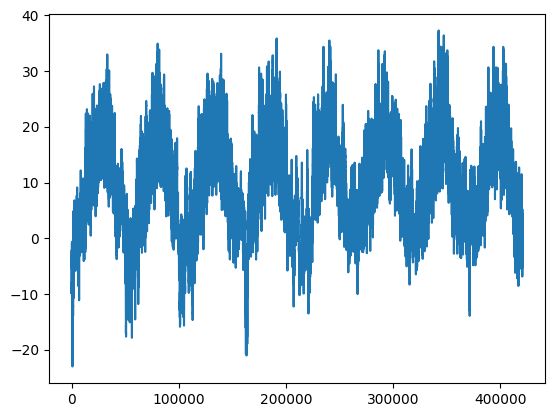

In [75]:
# Step 2.1: Visualize the data
plt.plot(range(len(Y)), Y)

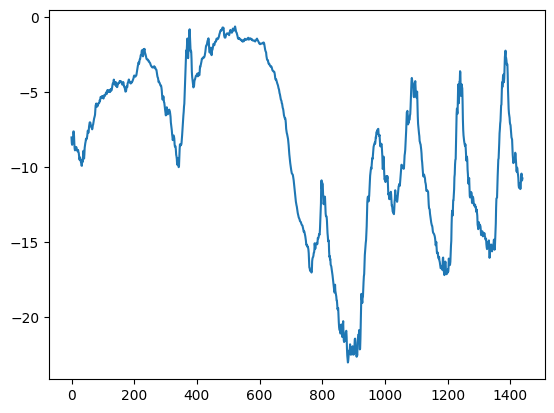

In [76]:
plt.plot(range(1440), Y[:1440])

In [9]:
# Step 3: Normalize Data

# IMPORTANT: The data must NOT be shuffled, because it is a time series
num_train = int(len(X) * 0.5)
num_val = int(len(X) * 0.25)
num_test = int(len(X) * 0.25)

# Normalize data
mean = X[:].mean(axis=0)
X -= mean
std = X[:].std(axis=0)
X /= std

X.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,0.874159,-2.073744,-2.127168,-2.058420,1.049513,-1.323744,-1.535058,-0.780533,-1.536774,-1.539264,2.293318,-0.713638,-0.761544,-0.258736
1,0.880140,-2.120042,-2.173024,-2.114880,1.055582,-1.336664,-1.556569,-0.782575,-1.555599,-1.560514,2.344597,-0.914698,-0.868360,-0.445639
2,0.875355,-2.131913,-2.184782,-2.119337,1.085927,-1.339249,-1.558960,-0.784617,-1.559364,-1.562876,2.355604,-1.258446,-1.240078,-0.036067
3,0.872963,-2.108171,-2.160091,-2.083678,1.104134,-1.332788,-1.544619,-0.786659,-1.544304,-1.548708,2.329339,-1.161159,-1.295622,0.268515
4,0.872963,-2.103422,-2.156563,-2.079221,1.098065,-1.331496,-1.542229,-0.786659,-1.544304,-1.546347,2.324586,-1.174130,-1.240078,0.456572


In [10]:
# Step 4: Create Data Generators
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_data = keras.utils.timeseries_dataset_from_array(
    X[:-delay], # size of sample
    targets = Y[delay:], # offset for target
    sampling_rate = sampling_rate,
    sequence_length=sequence_length,
    shuffle = True,
    batch_size=batch_size,
    start_index=0,
    end_index = num_train
)

val_data = keras.utils.timeseries_dataset_from_array(
    X[:-delay],
    targets = Y[delay:],
    sampling_rate = sampling_rate,
    sequence_length=sequence_length,
    shuffle = True,
    batch_size=batch_size,
    start_index= num_train,
    end_index = num_train + num_val
)

test_data = keras.utils.timeseries_dataset_from_array(
    X[:-delay],
    targets = Y[delay:],
    sampling_rate = sampling_rate,
    sequence_length=sequence_length,
    shuffle = True,
    batch_size=batch_size,
    start_index= num_train + num_val
)

# Note that each sample is consequtive, but the batches are shuffled

In [17]:
# Step 4.1: Check the shape of the data
for samples, targets in val_data:
    print(samples.shape, targets.shape)
    break

(256, 120, 14) (256,)


In [80]:
# Step 5: Create Baseline

# Idea is to take the MAE for every 24 hour interval and average results
def naive_baseline(X, std, mean):
    temp_data = X['T (degC)'] * std['T (degC)'] + mean['T (degC)']
    total_mse = np.mean(np.abs(temp_data - temp_data.shift(6 * 24)).dropna())
    return total_mse

print(f'Validation MAE: {naive_baseline(X[num_train:num_train+num_val], std, mean)}')
print(f'Test MAE: {naive_baseline(X[num_train+num_val:], std, mean)}')

Validation MAE: 2.4372657381297156
Test MAE: 2.617910736400877


In [89]:
# Step 6: Create A Simple Model

# Model Architecture
inputs = keras.Input(shape=(sequence_length, X.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation='relu')(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# Model Compilation
callbacks = [
    keras.callbacks.ModelCheckpoint('jena_dense.keras', save_best_only=True)
]

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

# Model Training
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
819/819 [==============================] - 5s 5ms/step - loss: 13.1296 - mae: 2.7916 - val_loss: 12.0863 - val_mae: 2.7424
Epoch 2/10
819/819 [==============================] - 4s 5ms/step - loss: 8.9823 - mae: 2.3633 - val_loss: 10.1376 - val_mae: 2.5114
Epoch 3/10
819/819 [==============================] - 4s 5ms/step - loss: 8.3101 - mae: 2.2761 - val_loss: 15.4703 - val_mae: 3.1156
Epoch 4/10
819/819 [==============================] - 4s 5ms/step - loss: 7.8771 - mae: 2.2168 - val_loss: 10.2619 - val_mae: 2.5277
Epoch 5/10
819/819 [==============================] - 4s 5ms/step - loss: 7.5569 - mae: 2.1733 - val_loss: 13.1963 - val_mae: 2.8710
Epoch 6/10
819/819 [==============================] - 4s 5ms/step - loss: 7.3169 - mae: 2.1410 - val_loss: 10.4423 - val_mae: 2.5575
Epoch 7/10
819/819 [==============================] - 4s 5ms/step - loss: 7.1452 - mae: 2.1153 - val_loss: 11.9799 - val_mae: 2.7236
Epoch 8/10
819/819 [==============================] - 4s 5ms/step - 

405/405 [==============================] - 2s 4ms/step - loss: 11.4774 - mae: 2.6677
Test MAE: 2.6677441596984863


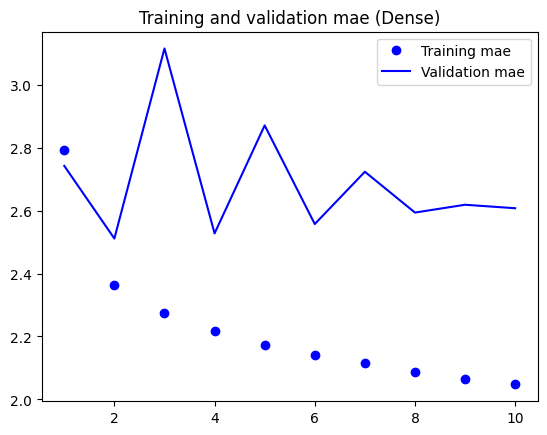

In [91]:
import matplotlib.pyplot as plt

# Print the test results
model = keras.models.load_model('jena_dense.keras')
print(f'Test MAE: {model.evaluate(test_data)[1]}')

# Plot history
mae = history.history['mae']
val_mae = history.history['val_mae']
epochs = range(1, len(mae) + 1)
plt.figure()
plt.plot(epochs, mae, 'bo', label='Training mae')
plt.plot(epochs, val_mae, 'b', label='Validation mae')
plt.title('Training and validation mae (Dense)')
plt.legend()
plt.show()

In [92]:
# Step 7: Create a simple CNN model (assuming invariance across time)

# Model Architecture
model = keras.Input(shape=(sequence_length, X.shape[-1]))
x = layers.Conv1D(8, 24, activation='relu')(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation='relu')(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation='relu')(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# Model Compilation
callbacks = [
    keras.callbacks.ModelCheckpoint('jena_conv.keras', save_best_only=True)
]

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

# Model Training
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10


2024-03-26 12:01:22.592916: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


819/819 [==============================] - 7s 7ms/step - loss: 22.6577 - mae: 3.7292 - val_loss: 15.7916 - val_mae: 3.1317
Epoch 2/10
819/819 [==============================] - 5s 6ms/step - loss: 15.8823 - mae: 3.1553 - val_loss: 14.3690 - val_mae: 2.9820
Epoch 3/10
819/819 [==============================] - 5s 6ms/step - loss: 14.2199 - mae: 2.9855 - val_loss: 14.0586 - val_mae: 2.9546
Epoch 4/10
819/819 [==============================] - 4s 5ms/step - loss: 13.2128 - mae: 2.8832 - val_loss: 14.3745 - val_mae: 2.9784
Epoch 5/10
819/819 [==============================] - 4s 5ms/step - loss: 12.5060 - mae: 2.8053 - val_loss: 14.0874 - val_mae: 2.9403
Epoch 6/10
819/819 [==============================] - 4s 5ms/step - loss: 11.9440 - mae: 2.7428 - val_loss: 14.1942 - val_mae: 2.9532
Epoch 7/10
819/819 [==============================] - 4s 5ms/step - loss: 11.5211 - mae: 2.6924 - val_loss: 14.0607 - val_mae: 2.9303
Epoch 8/10
819/819 [==============================] - 5s 5ms/step - loss:

405/405 [==============================] - 2s 4ms/step - loss: 15.5346 - mae: 3.1349
Test MAE: 3.134888172149658


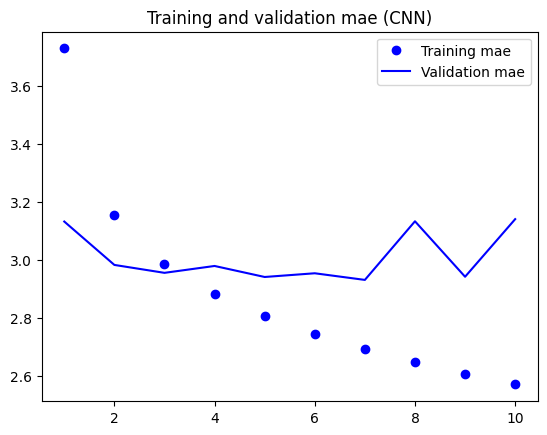

In [93]:
# Print the test results
model = keras.models.load_model('jena_conv.keras')
print(f'Test MAE: {model.evaluate(test_data)[1]}')

# Plot history
mae = history.history['mae']
val_mae = history.history['val_mae']
epochs = range(1, len(mae) + 1)
plt.figure()
plt.plot(epochs, mae, 'bo', label='Training mae')
plt.plot(epochs, val_mae, 'b', label='Validation mae')
plt.title('Training and validation mae (CNN)')
plt.legend()
plt.show()

In [121]:
# Step 8: Create a simple RNN model

input_shape = (sequence_length, X.shape[-1])
print(input_shape)

# Model Architecture
inputs = keras.Input(shape=input_shape)
x = layers.LSTM(16)(inputs) # unroll=True is used to speed up training for short sequences with cuDNN
# x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# Model Compilation
callbacks = [
    keras.callbacks.ModelCheckpoint('jena_lstm_dropout.keras', save_best_only=True)
]

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

# Model Training
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    callbacks=callbacks
)

(120, 14)
Epoch 1/15
819/819 [==============================] - 7s 7ms/step - loss: 41.3056 - mae: 4.6610 - val_loss: 12.4756 - val_mae: 2.6925
Epoch 2/15
819/819 [==============================] - 6s 7ms/step - loss: 10.9161 - mae: 2.5556 - val_loss: 10.5094 - val_mae: 2.4802
Epoch 3/15
819/819 [==============================] - 6s 7ms/step - loss: 9.6892 - mae: 2.4174 - val_loss: 11.6794 - val_mae: 2.5538
Epoch 4/15
819/819 [==============================] - 6s 7ms/step - loss: 9.3011 - mae: 2.3625 - val_loss: 12.0186 - val_mae: 2.5714
Epoch 5/15
819/819 [==============================] - 6s 7ms/step - loss: 8.9591 - mae: 2.3192 - val_loss: 11.7103 - val_mae: 2.5472
Epoch 6/15
819/819 [==============================] - 6s 7ms/step - loss: 8.6720 - mae: 2.2839 - val_loss: 11.5612 - val_mae: 2.5289
Epoch 7/15
819/819 [==============================] - 6s 7ms/step - loss: 8.4344 - mae: 2.2542 - val_loss: 11.8668 - val_mae: 2.5580
Epoch 8/15
819/819 [==============================] - 6s 

405/405 [==============================] - 2s 4ms/step - loss: 11.2408 - mae: 2.6329
Test MAE: 2.6329448223114014


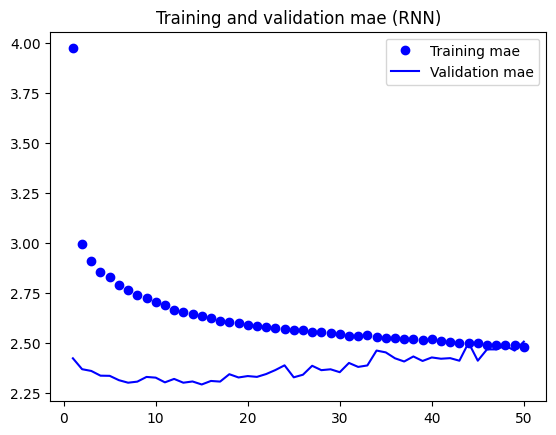

In [16]:
# Print the test results
model = keras.models.load_model('jena_lstm_dropout.keras')
print(f'Test MAE: {model.evaluate(test_data)[1]}')

# Plot history
mae = history.history['mae']
val_mae = history.history['val_mae']
epochs = range(1, len(mae) + 1)
plt.figure()
plt.plot(epochs, mae, 'bo', label='Training mae')
plt.plot(epochs, val_mae, 'b', label='Validation mae')
plt.title('Training and validation mae (RNN)')
plt.legend()
plt.show()

In [14]:
# Step 9: Create a GRU model

input_shape = (sequence_length, X.shape[-1])
print(input_shape)

# Model Architecture
inputs = keras.Input(shape=input_shape)
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs) # unroll=True is used to speed up training for short sequences with cuDNN
x = layers.GRU(32, recurrent_dropout=0.5)(inputs) # unroll=True is used to speed up training for short sequences with cuDNN
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# Model Compilation
callbacks = [
    keras.callbacks.ModelCheckpoint('jena_stacked_gru_dropout.keras', save_best_only=True)
]

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

# Model Training
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=callbacks
)

(120, 14)
Epoch 1/50
819/819 [==============================] - 91s 109ms/step - loss: 29.0497 - mae: 3.9702 - val_loss: 9.7384 - val_mae: 2.4220
Epoch 2/50
819/819 [==============================] - 89s 109ms/step - loss: 14.8038 - mae: 2.9921 - val_loss: 9.2476 - val_mae: 2.3675
Epoch 3/50
819/819 [==============================] - 89s 109ms/step - loss: 13.9791 - mae: 2.9059 - val_loss: 9.1940 - val_mae: 2.3588
Epoch 4/50
819/819 [==============================] - 89s 109ms/step - loss: 13.5519 - mae: 2.8548 - val_loss: 8.9654 - val_mae: 2.3352
Epoch 5/50
819/819 [==============================] - 89s 109ms/step - loss: 13.2621 - mae: 2.8261 - val_loss: 9.0345 - val_mae: 2.3344
Epoch 6/50
819/819 [==============================] - 89s 109ms/step - loss: 12.9284 - mae: 2.7901 - val_loss: 8.8705 - val_mae: 2.3127
Epoch 7/50
819/819 [==============================] - 89s 109ms/step - loss: 12.6215 - mae: 2.7626 - val_loss: 8.7986 - val_mae: 2.3000
Epoch 8/50
819/819 [==================

405/405 [==============================] - 10s 23ms/step - loss: 9.8447 - mae: 2.4526
Test MAE: 2.4525763988494873


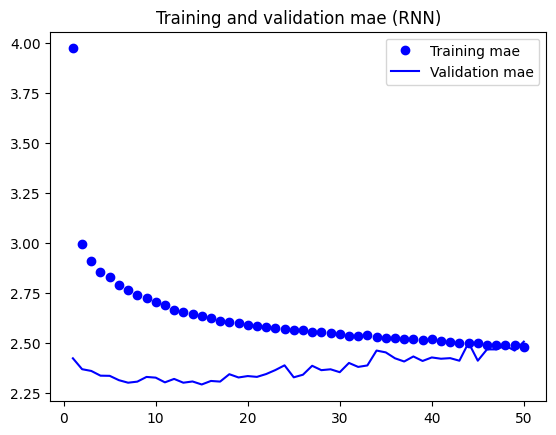

In [15]:
# Print the test results
model = keras.models.load_model('jena_stacked_gru_dropout.keras')
print(f'Test MAE: {model.evaluate(test_data)[1]}')

# Plot history
mae = history.history['mae']
val_mae = history.history['val_mae']
epochs = range(1, len(mae) + 1)
plt.figure()
plt.plot(epochs, mae, 'bo', label='Training mae')
plt.plot(epochs, val_mae, 'b', label='Validation mae')
plt.title('Training and validation mae (RNN)')
plt.legend()
plt.show()